## House Prices in Tehran


**Importing the required Libraries:** 

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline


**Reading the .csv File:**

In [71]:
# Read the CSV file
df = pd.read_csv("House_data.csv")
# Take a look at the dataset
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


**Make a Histogram to Figure out Which Areas are Outlier Data:**

C:\Users\Sina\AppData\Local\Temp\ipykernel_13736\4065765326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['Area'] = pd.to_numeric(cdf['Area'], errors='coerce')


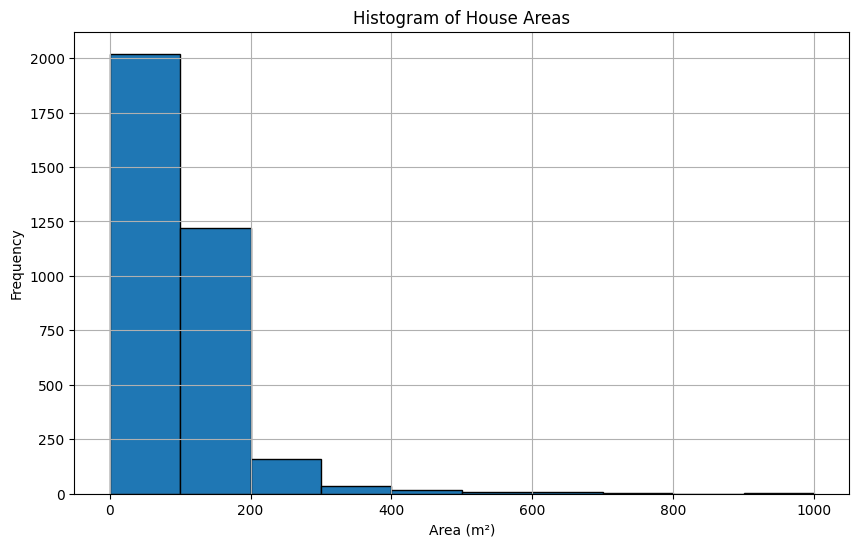

In [72]:
# Select the 'Area' column
cdf = df[['Area']]

# Convert the 'Area' column to numeric values to handle any non-numeric entries
cdf['Area'] = pd.to_numeric(cdf['Area'], errors='coerce')

# Drop any NaN values that resulted from conversion
cdf = cdf.dropna()

# Define the bin width
bin_width = 100

# Calculate the number of bins
bins = range(0, int(cdf['Area'].max()) + bin_width, bin_width)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(cdf['Area'], bins=bins, edgecolor='black')
plt.title('Histogram of House Areas')
plt.xlabel('Area (m²)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


C:\Users\Sina\AppData\Local\Temp\ipykernel_13736\2367266194.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['Area'] = pd.to_numeric(cdf['Area'], errors='coerce')


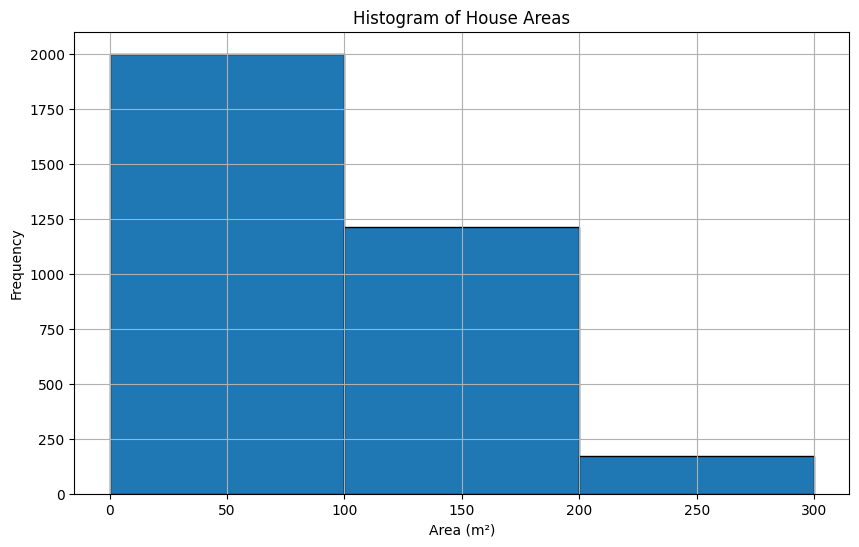

Empty DataFrame
Columns: [Area, Room, Parking, Warehouse, Elevator, Address, Price, Price(USD)]
Index: []


In [73]:
# Remove rows with an area over 300 m²
df = df[pd.to_numeric(df['Area'], errors='coerce') <= 300]

# Remove rows where the address is empty or missing
df = df[df['Address'].notna() & df['Address'].str.strip().astype(bool)]

# Select the 'Area' column
cdf = df[['Area']]

# Convert the 'Area' column to numeric values to handle any non-numeric entries
cdf['Area'] = pd.to_numeric(cdf['Area'], errors='coerce')

# Drop any NaN values that resulted from conversion
cdf = cdf.dropna()

# Define the bin width
bin_width = 100

# Calculate the number of bins
bins = range(0, int(cdf['Area'].max()) + bin_width, bin_width)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(cdf['Area'], bins=bins, edgecolor='black')
plt.title('Histogram of House Areas')
plt.xlabel('Area (m²)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Check for rows with missing or empty addresses
missing_address = df[df['Address'].isna() | df['Address'].str.strip().eq('')]

# Print the rows with missing or empty addresses
print(missing_address)


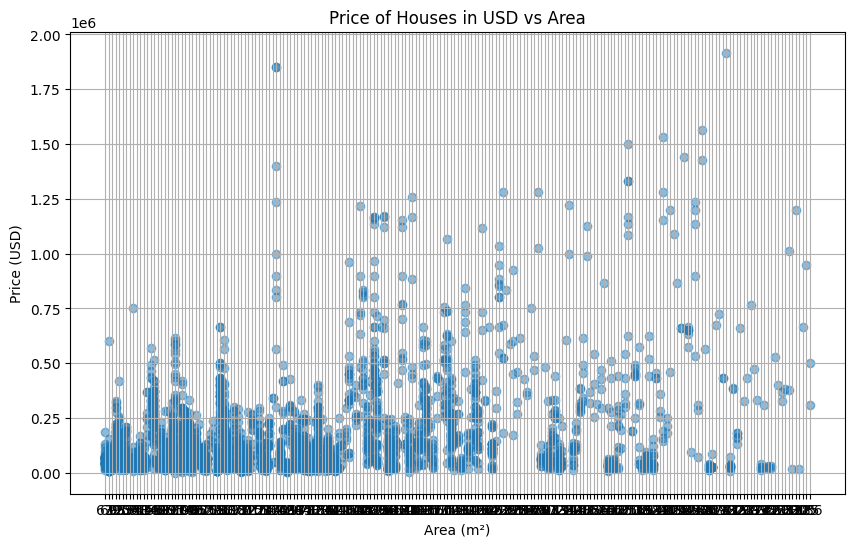

In [74]:
# Plot the price of houses in USD versus area 
plt.figure(figsize=(10, 6))
plt.scatter(df['Area'], df['Price(USD)'], alpha=0.5)
plt.title('Price of Houses in USD vs Area')
plt.xlabel('Area (m²)')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

In [75]:
# Group by the 'Address' column
try:
    grouped = df.groupby('Address')
except KeyError as e:
    print(f"Error: Column 'Address' not found in the dataset. Available columns are: {df.columns.tolist()}")
    raise
except Exception as e:
    print(f"Unexpected error during grouping: {e}")
    raise

# Display the groups
#for address, group in grouped:
#    print(f"Group for address: {address}")
#    print(group.head())  # Display the first few rows of each group
#    print("\n")

# Save each group to a separate CSV file
for address, group in grouped:
    try:
        # Replace any invalid characters in the filename
        safe_address = "".join([c if c.isalnum() else "_" for c in address])
        group.to_csv(f'{safe_address}.csv', index=False)
    except Exception as e:
        print(f"Error saving group for address '{address}': {e}")
        raise

# Calculate the average price for each group
average_prices = grouped['Price(USD)'].mean().reset_index()

# Rename the columns for clarity
average_prices.columns = ['Address', 'Average Price USD']

# Display the new DataFrame
print(average_prices)

         Address  Average Price USD
0         Abazar      161613.635909
1      Abbasabad      107666.665000
2         Abuzar       50944.443333
3       Afsarieh       62222.221667
4          Ahang       36666.670000
..           ...                ...
184  Yousef Abad      234399.123158
185        Zafar      191644.445556
186   Zaferanieh      655505.333200
187    Zargandeh      235600.000000
188    Zibadasht      145000.000000

[189 rows x 2 columns]
